## Notebook to combine individual replication cohort samples into single anndata object with donor sample info annotated

Replication data: 
NABEC snRNA from Xylena Reed


In [1]:
!date

Thu Nov  9 10:15:37 EST 2023


#### import libraries

In [2]:
from pandas import read_csv, DataFrame
from scanpy import read_h5ad, read_10x_h5
from anndata import concat as ad_concat
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
from seaborn import barplot

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

#### set notebook variables

In [3]:
# naming
project = 'aging_phase1_nabec'

# directories
wrk_dir = '/labshare/raph/datasets/adrd_neuro/brain_aging/phase1'
replication_dir = f'{wrk_dir}/replication'

# in files
info_file = f'{replication_dir}/nabec.aug2020.sample_info.txt'

# out files
raw_anndata_file = f'{replication_dir}/{project}.raw.h5ad'

# variables
DEBUG = True
nabec_samples = ['UM1540', 'UM1710', 'UM4546', 'UM4789', 'UM5088', 
                 'UM5171', 'UM1541', 'UM1818', 'UM4726', 'UM5028', 
                 'UM5123', 'UM602']

#### functions

In [4]:
def retrive_sample_info(this_id: str, df: DataFrame) -> (str, float, str, int):
    """
        format sample ID, lookup info and return that
            this_id:
                the ID that will be formatted and key in lookup
            df:
                information dataframe
            returns:
                ID, PMI, Sex, Age
    """
    sample_key = this_id.replace('UM', 'UMARY-')
    sample_info = df.loc[df.SampleId == sample_key]
    pmi = sample_info.PMI.values[0]
    sex = sample_info.Sex.values[0]
    age = int(sample_info.Age.values[0])
    return sample_key, pmi, sex, age

# function to plot the barcode counts by sample
def plot_sample_barcode_counts(this_df, sample_name, id_col='sample_id'):
    with rc_context({'figure.figsize': (12, 12), 'figure.dpi': 100}):
        plt.style.use('seaborn-talk')    
        barplot(x=this_df[id_col].value_counts().index, 
                y=this_df[id_col].value_counts().values, 
                order=this_df[id_col].value_counts().index,
                palette='Blues_d')
        plt.xticks(rotation=90, fontsize=8)
        plt.tight_layout()
        plt.title(sample_name)
        plt.ylabel('barcode counts')
        plt.show()
    print(this_df[id_col].value_counts())  

### load data

#### load NABEC subject/sample info

In [5]:
info_df = read_csv(info_file)
print(f'info shape {info_df.shape}')
if DEBUG:
    display(info_df.sample(5))

info shape (436, 18)


,SampleId,Group,Member,Ethnicity,PMI,Sex,Age,Box,RIN_mrna,RIN_totalrna,Caged,GWASCHIP,EXOMED,mRNAseq,totalRNAseq,CpG450k,WGSed,WGS_TS
123,SH-97-17,SH,97-17,US Caucasian,2.66,male,78.0,NaN,NaN,NaN,NaN,TRUE,TRUE,NaN,NaN,TRUE,TRUE,frontal_cortex
278,UMARY-1379,UMARY,1379,US Caucasian,15.00,female,53.0,BOX6,7.8,7.8,No,TRUE,TRUE,yes,TRUE,TRUE,TRUE,frontal_cortex
163,KEN-1184,UKY,1184,US Caucasian,3.00,female,92.0,NaN,NaN,8.3,NaN,TRUE,TRUE,NaN,TRUE,TRUE,TRUE,NaN
381,UMARY-4592,UMARY,4592,US Caucasian,14.00,male,38.0,BOX5,Degraded,6.2,No,TRUE,TRUE,NaN,TRUE,TRUE,TRUE,frontal_cortex
161,KEN-1170,UKY,1170,US Caucasian,2.50,female,84.0,NaN,NaN,7.9,NaN,TRUE,TRUE,NaN,TRUE,TRUE,NaN,NaN


#### load the snRNA data

In [6]:
adata_list = []
for sample in nabec_samples:
    sample_id, pmi, sex, age = retrive_sample_info(sample, info_df)
    print(sample_id, pmi, sex, age)
    in_file = f'{replication_dir}/{sample}_RNA.h5'
    this_adata = read_10x_h5(in_file)
    this_adata.var_names_make_unique()
    this_adata.obs['sample_id'] = sample_id
    this_adata.obs['pmi'] = pmi
    this_adata.obs['sex'] = sex
    this_adata.obs['age'] = age
    adata_list.append(this_adata)

/home/gibbsr/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/gibbsr/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/gibbsr/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/gibbsr/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/gibbsr/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them u

### combine the loaded data

In [7]:
adata_all = ad_concat(adata_list)
adata_all.obs_names_make_unique()
print(adata_all)
if DEBUG:
    display(adata_all.obs.sample(10))
    display(adata_all.var.sample(10))

AnnData object with n_obs × n_vars = 79600 × 36601
    obs: 'sample_id', 'pmi', 'sex', 'age'


/home/gibbsr/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


,sample_id,pmi,sex,age
TTGCTCTCACTTCATC-1,UMARY-4546,22.0,female,86
GATCCGTCACAAACTT-1,UMARY-5088,23.0,male,66
TAGCTTGCATTGTCAG-1,UMARY-5171,5.0,male,79
CTCCATCAGCTGTCAG-1,UMARY-602,15.0,male,27
TCATACTTCTGTGCAG-1,UMARY-5028,18.0,male,67
TTATGACCATAACGGG-1,UMARY-5171,5.0,male,79
AACCTTAAGGTATTGC-1,UMARY-1540,7.0,male,28
TACTTGTTCCTAATTC-1,UMARY-4546,22.0,female,86
TGATCCTGTACTGAAT-1,UMARY-5171,5.0,male,79
TAAAGCCTCTGTAATG-1,UMARY-5088,23.0,male,66


""
SLC6A8
SH2D3A
GON4L
AC025947.1
LINC02668
AC008751.3
AC011510.1
SNHG17
AC079203.2
AP003307.1


### save the combined data

In [8]:
adata_all.write(raw_anndata_file)

### visualize cell counts

In [9]:
adata_all.obs.sample_id.value_counts()

sample_id
UMARY-5088    11806
UMARY-1540     9255
UMARY-5171     9169
UMARY-1710     8770
UMARY-4789     8183
UMARY-1541     7460
UMARY-4546     5762
UMARY-1818     5166
UMARY-602      4913
UMARY-5123     4458
UMARY-4726     3071
UMARY-5028     1587
Name: count, dtype: int64

In [14]:
adata_all.obs.age.value_counts()

age
28    12326
66    11806
79     9169
26     8770
72     8183
20     7460
86     5762
76     5166
27     4913
61     4458
67     1587
Name: count, dtype: int64

In [15]:
adata_all.obs.sex.value_counts()

sex
male      49425
female    30175
Name: count, dtype: int64

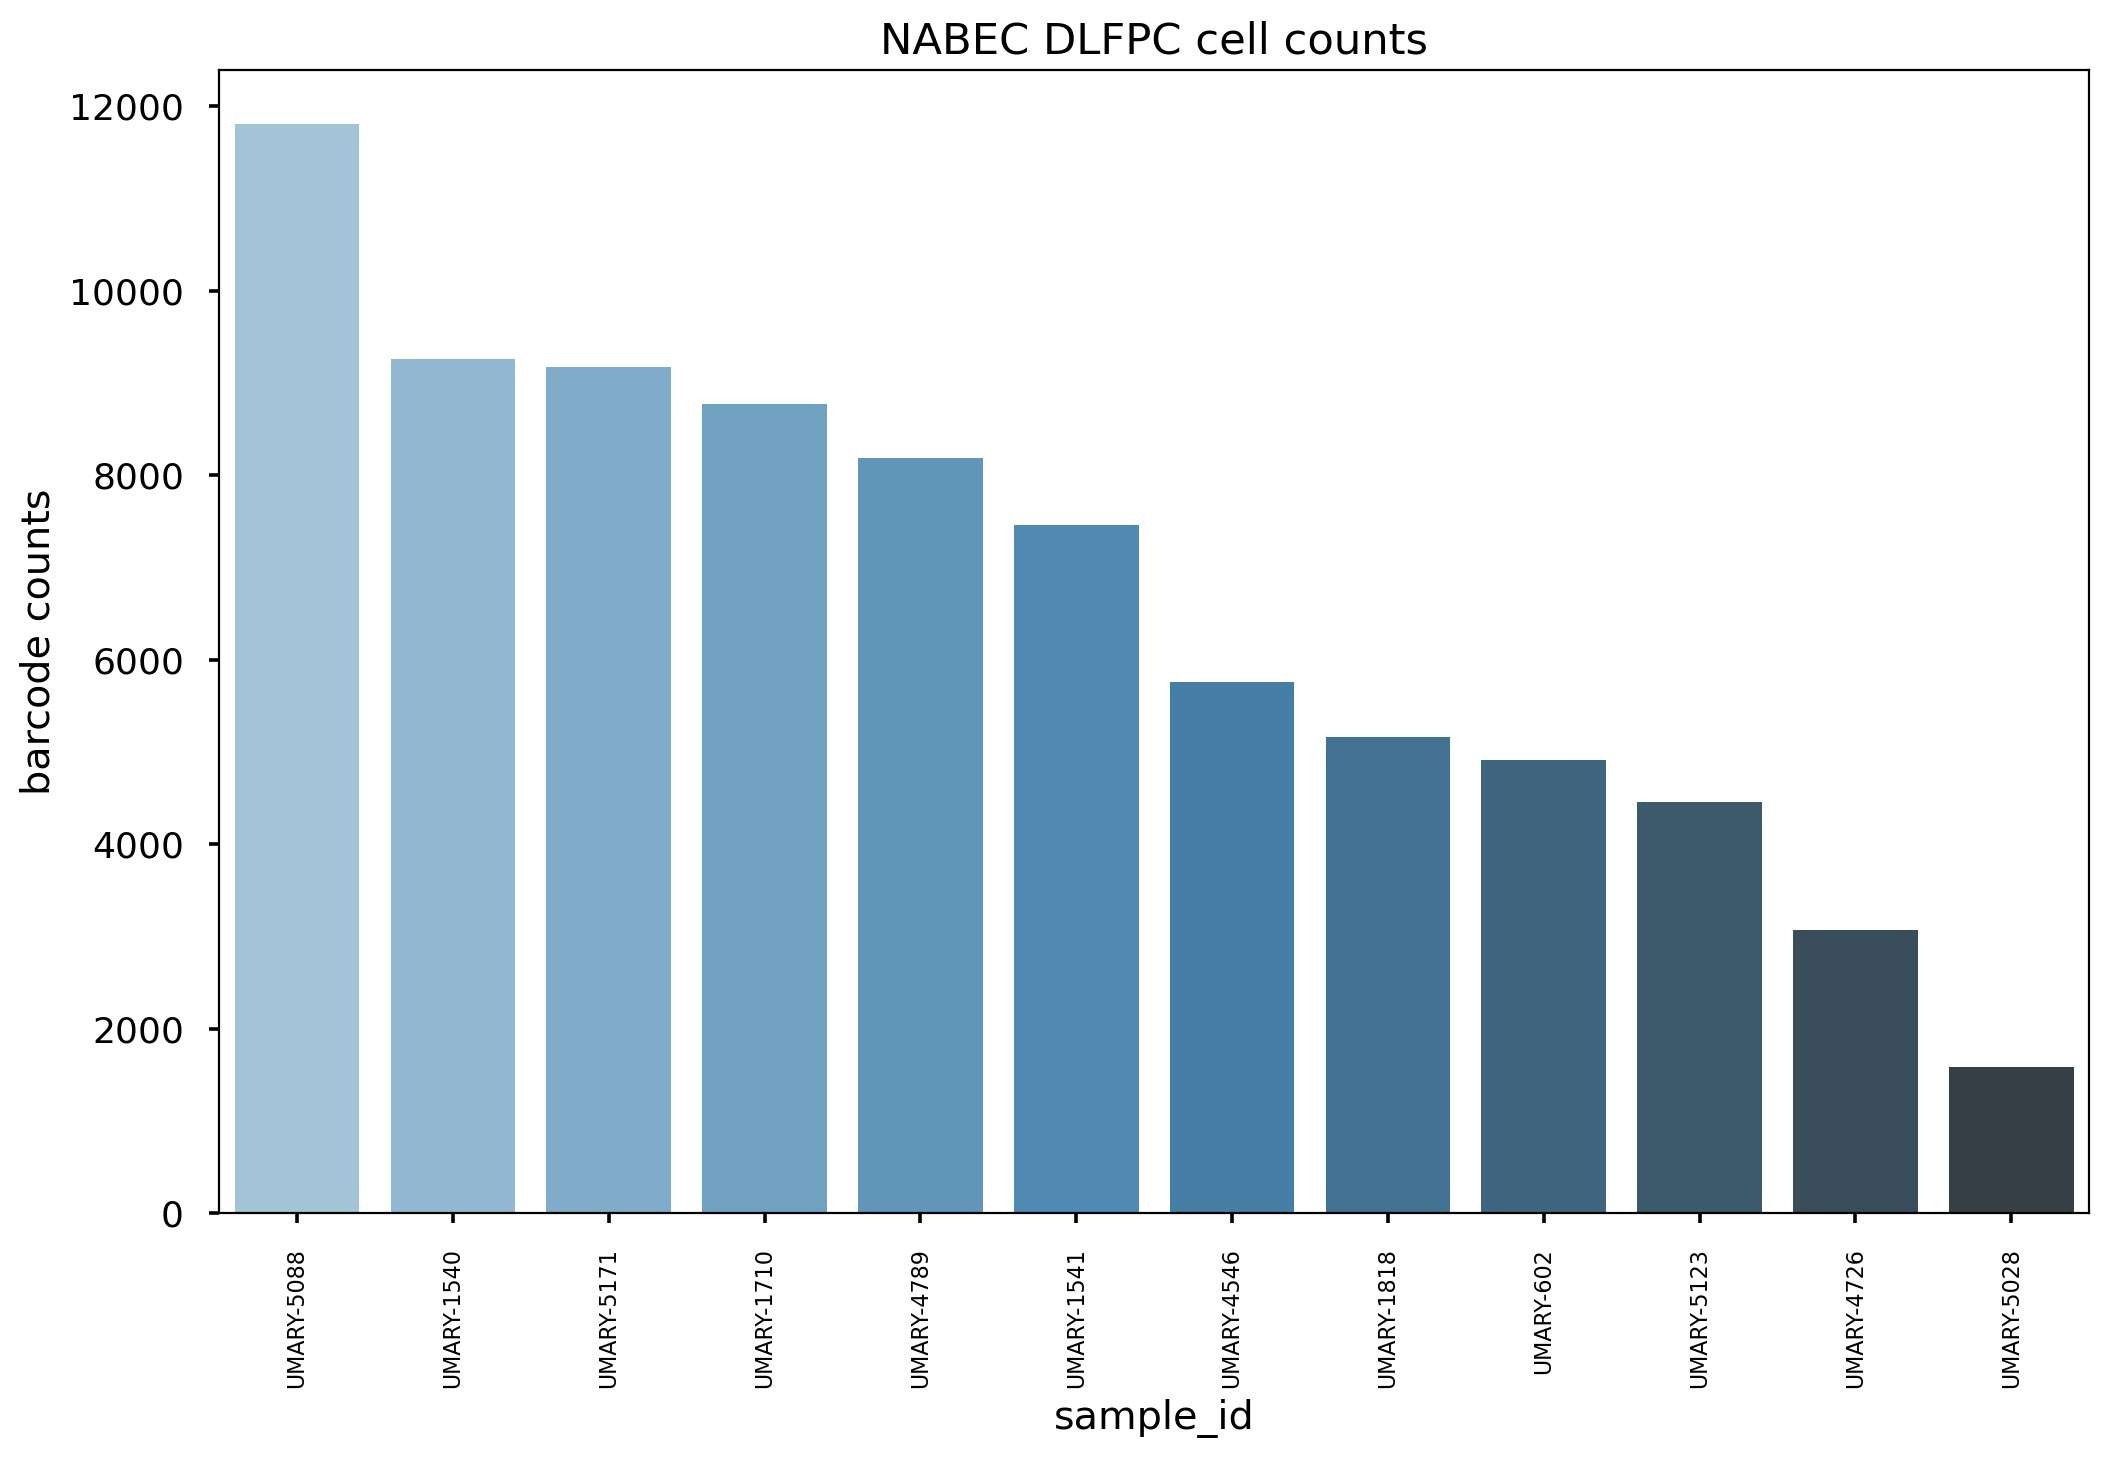

sample_id
UMARY-5088    11806
UMARY-1540     9255
UMARY-5171     9169
UMARY-1710     8770
UMARY-4789     8183
UMARY-1541     7460
UMARY-4546     5762
UMARY-1818     5166
UMARY-602      4913
UMARY-5123     4458
UMARY-4726     3071
UMARY-5028     1587
Name: count, dtype: int64


In [10]:
plot_sample_barcode_counts(adata_all.obs, 'NABEC DLFPC cell counts')

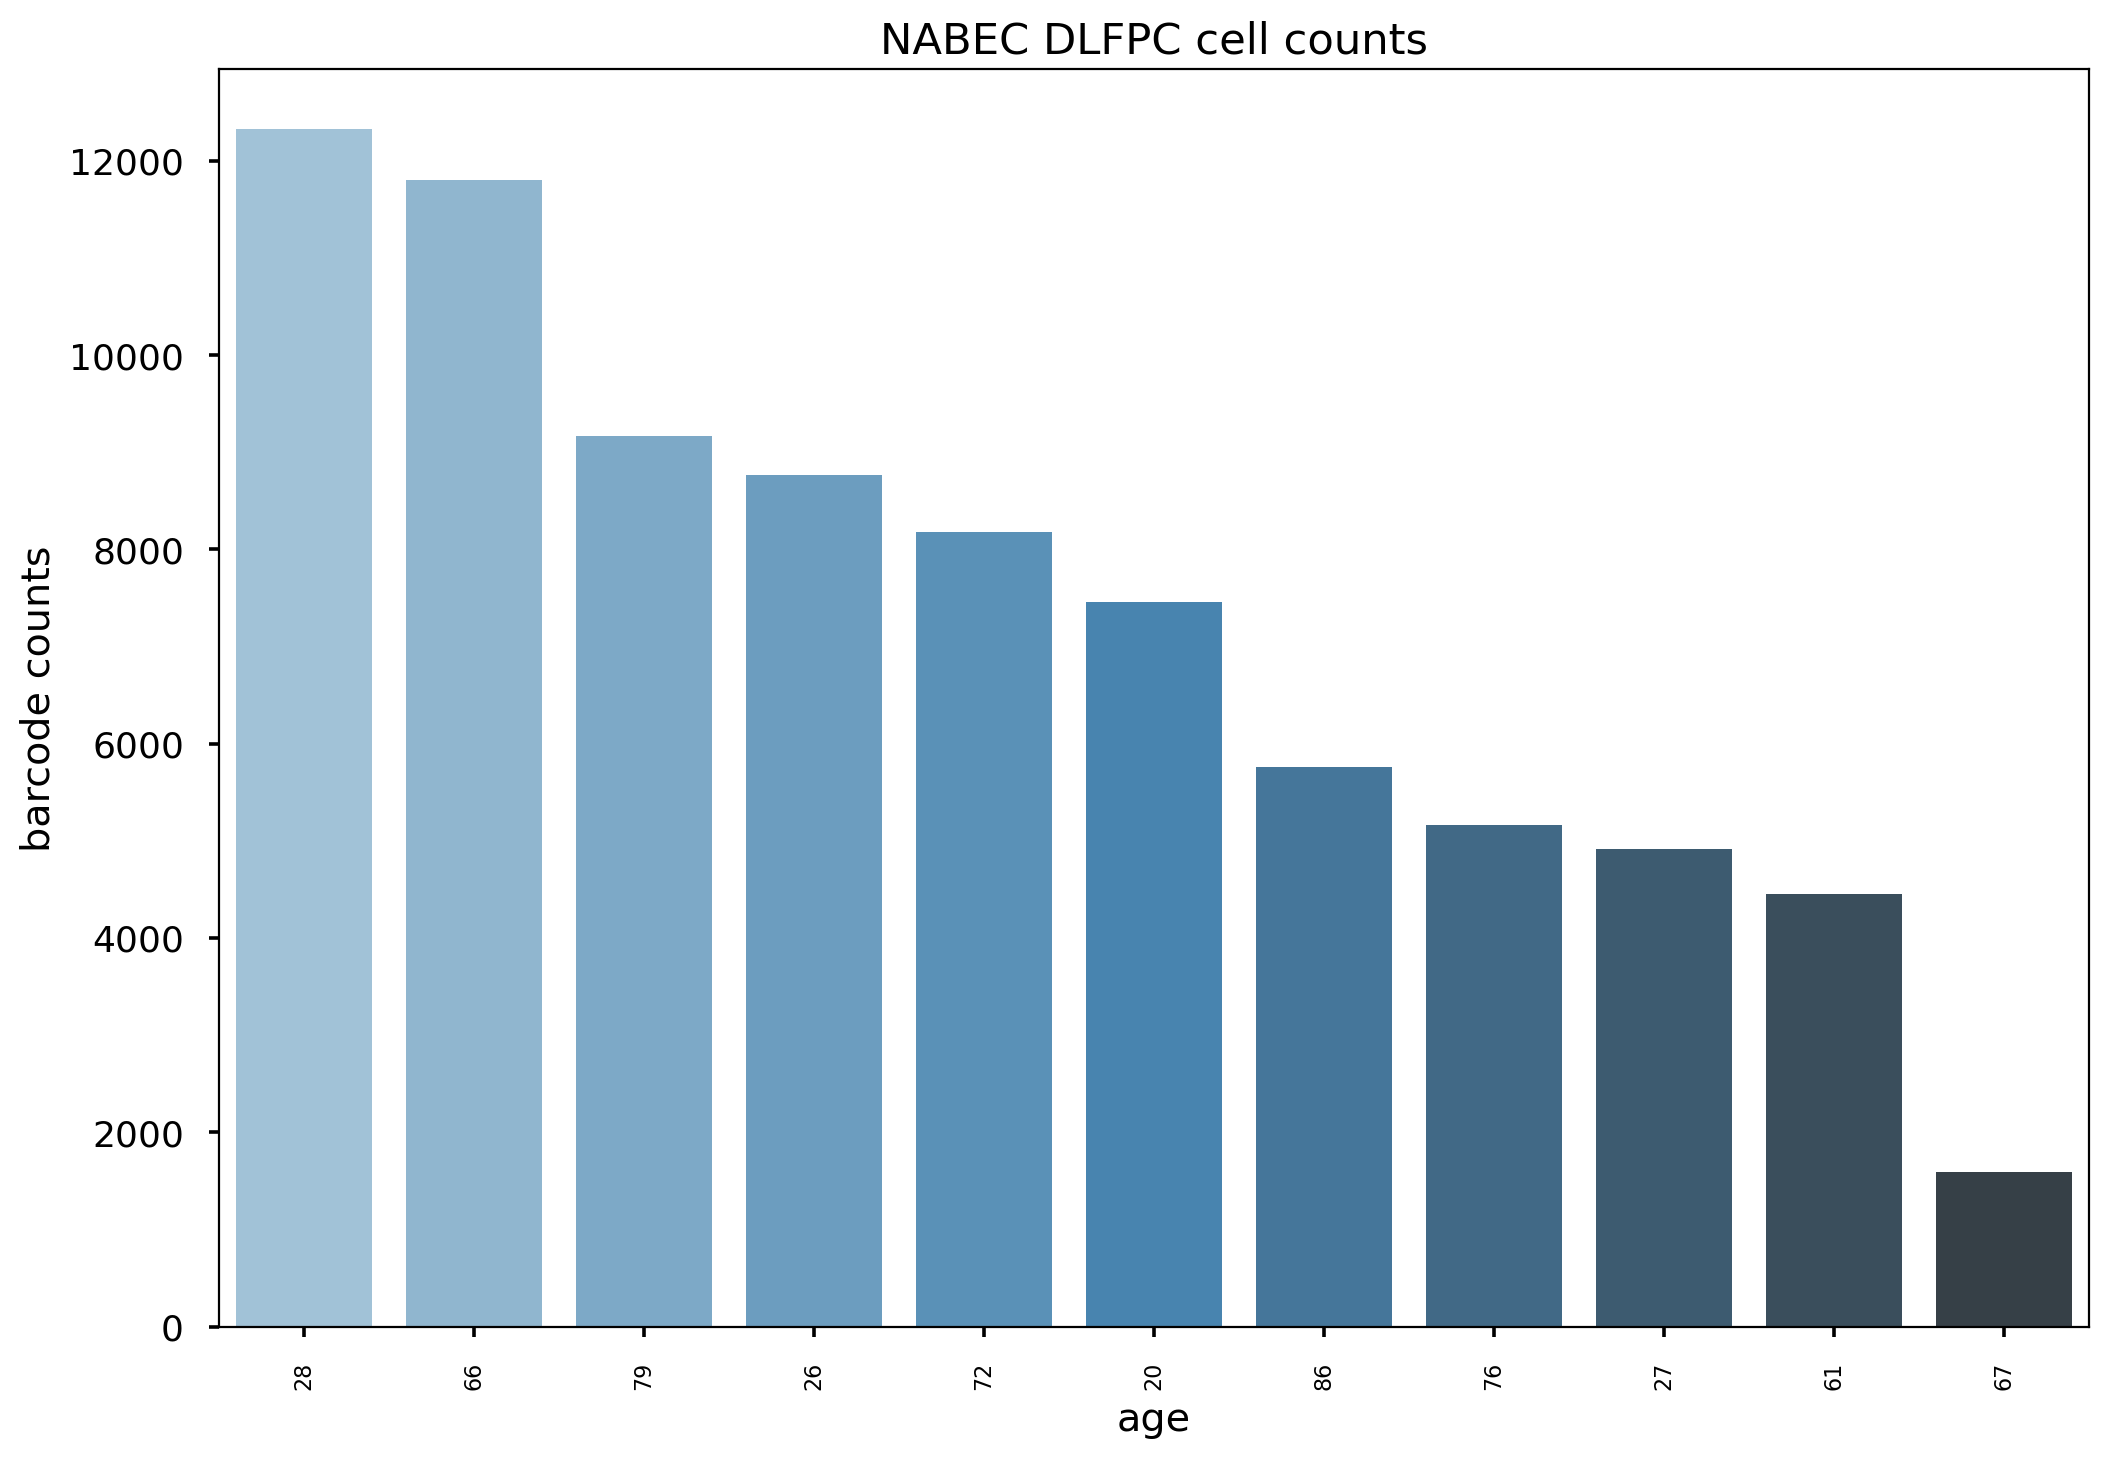

age
28    12326
66    11806
79     9169
26     8770
72     8183
20     7460
86     5762
76     5166
27     4913
61     4458
67     1587
Name: count, dtype: int64


In [11]:
plot_sample_barcode_counts(adata_all.obs, 'NABEC DLFPC cell counts', 'age')

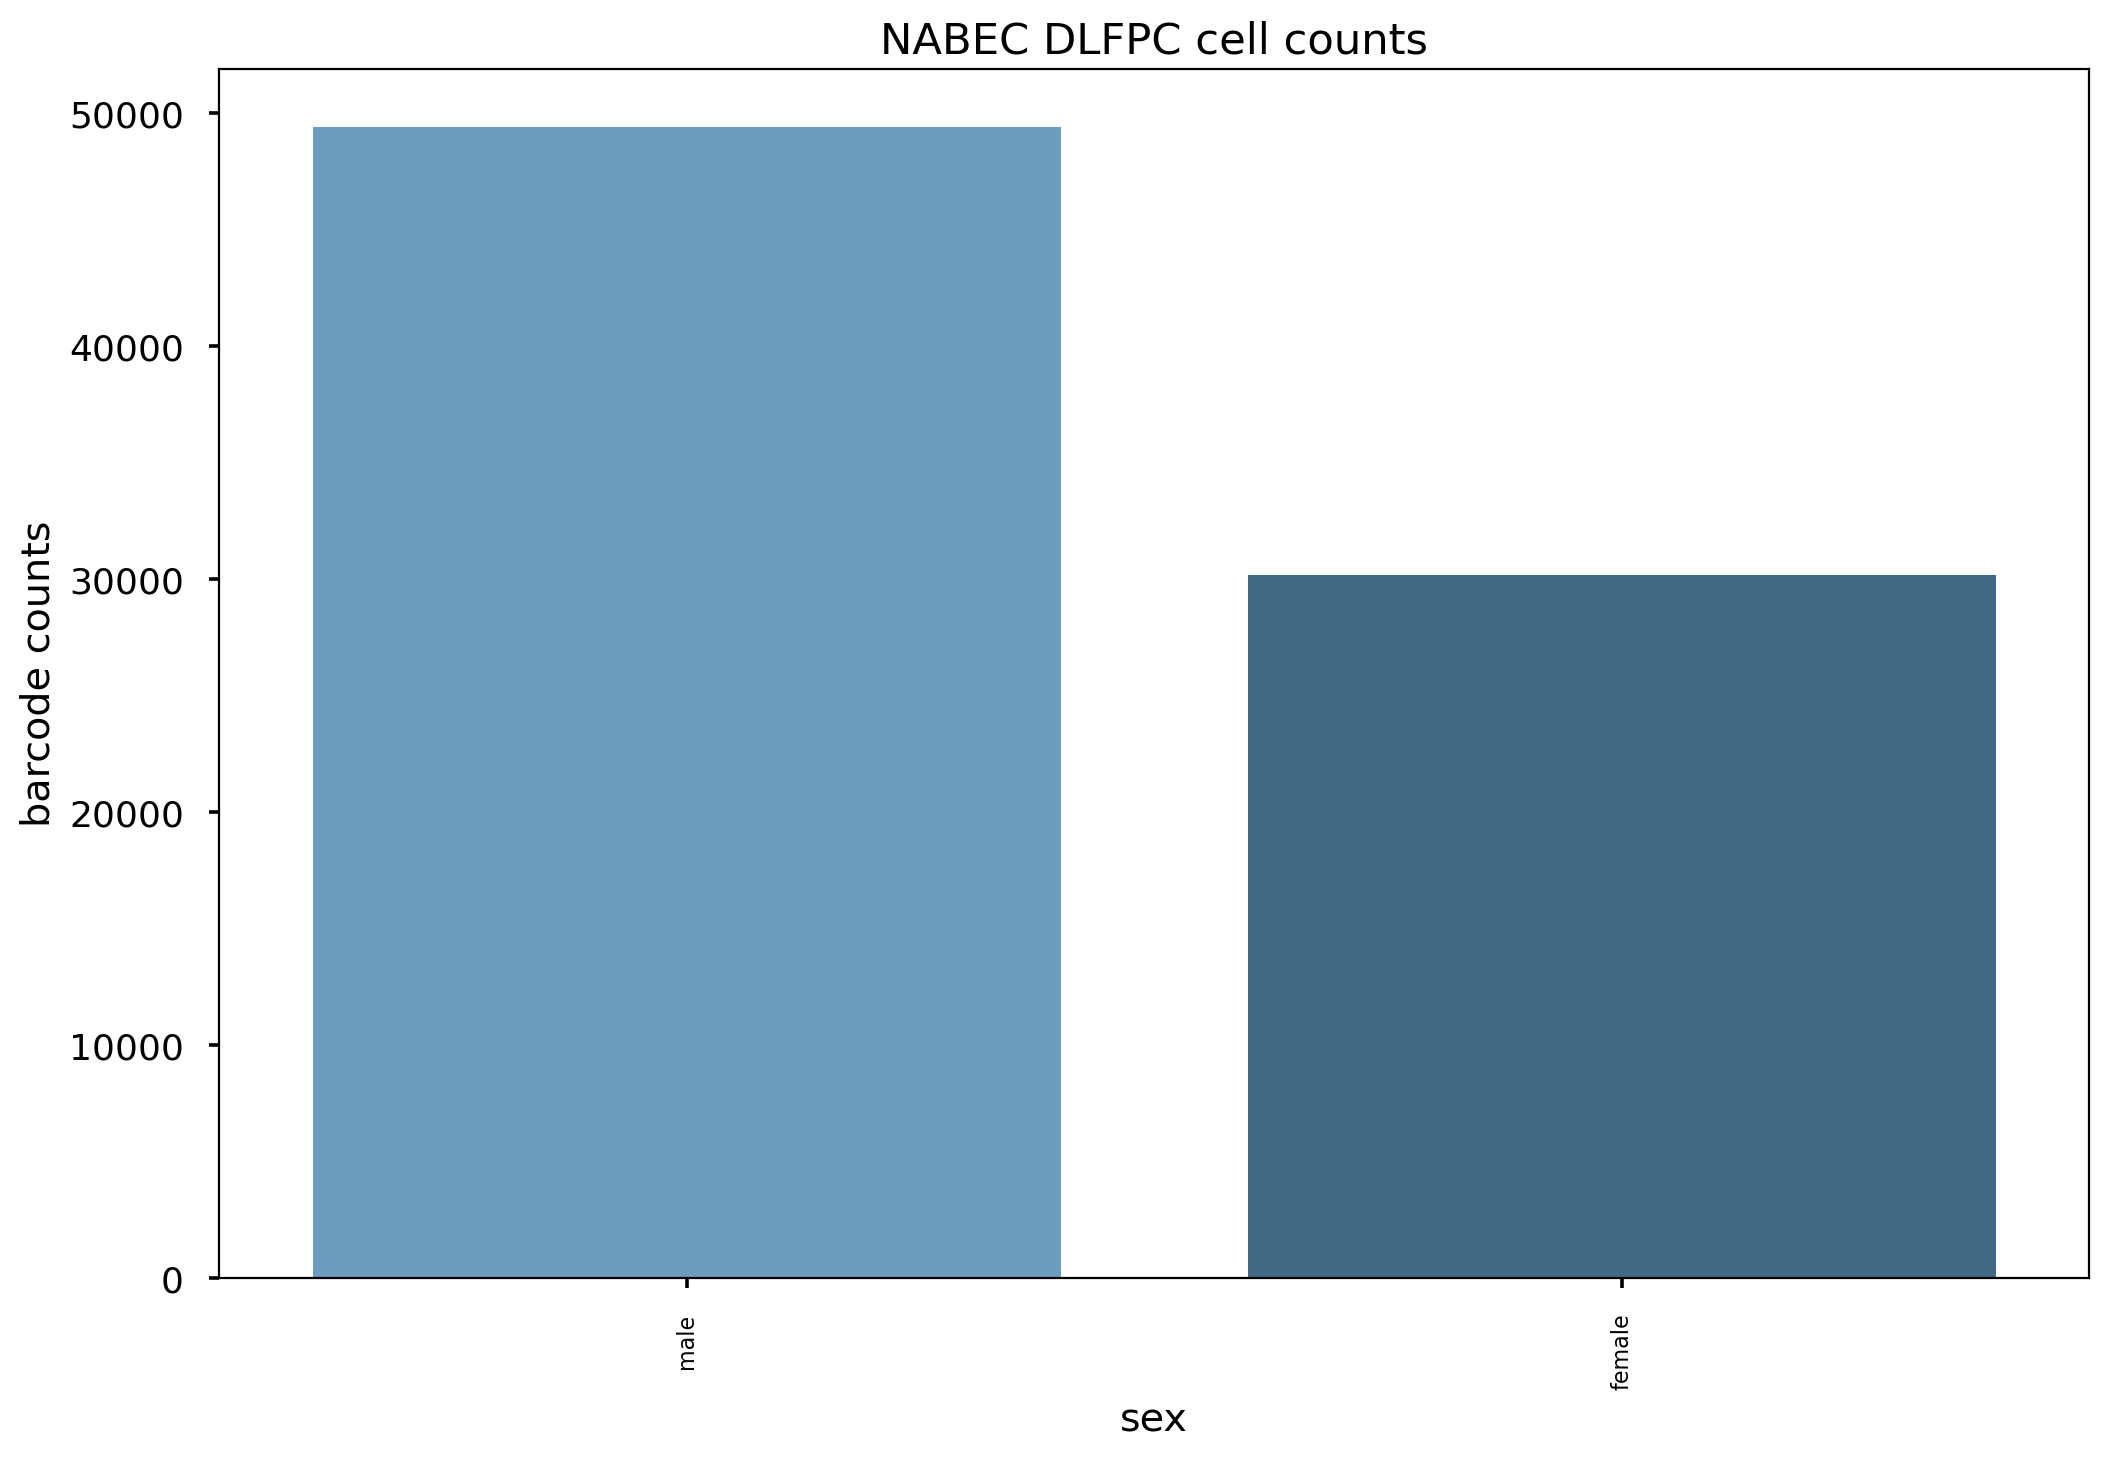

sex
male      49425
female    30175
Name: count, dtype: int64


In [12]:
plot_sample_barcode_counts(adata_all.obs, 'NABEC DLFPC cell counts', 'sex')

In [13]:
!date

Thu Nov  9 10:16:00 EST 2023
